In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics")


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, fbeta_score, make_scorer
from sklearn.metrics import precision_recall_curve, auc
from scipy.sparse import hstack, csr_matrix,vstack


### Modelling

#### Reading the data frame from csv file

In [24]:
train = pd.read_csv(r"train.csv")
val = pd.read_csv(r"validation.csv")
test = pd.read_csv(r"test.csv")

# seperating the Features and target variable
X_train, y_train = train.drop("spam", axis = 1), train["spam"]
X_val, y_val = val.drop("spam", axis = 1), val["spam"]
X_test, y_test = test.drop("spam", axis = 1), test["spam"]

#### Vectorization using TF-IDF

In [25]:
def df_after_vectorization(X_train,X,no_of_words):
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train["text"])
    X = vectorizer.transform(X['text'])
    no_of_words_column = csr_matrix(no_of_words['no_of_words'].values.reshape(-1, 1))
    # Horizontally stack the sparse matrices
    X_combined = hstack([X, no_of_words_column])
    return X_combined

    

In [26]:
vectorizer = TfidfVectorizer()
X_val = df_after_vectorization(X_train,X_val,val)
X_test = df_after_vectorization(X_train,X_test,test)
X_train = vectorizer.fit_transform(X_train["text"])
no_of_words_column = csr_matrix(train['no_of_words'].values.reshape(-1,1))
X_train = hstack([X_train,no_of_words_column])


#### Functions for viewing confusion matrix and evaluating the model

In [27]:
def display_confusion_matrix(y_actual, y_pred):
    target_labels = ["Not Spam", "Spam"]
    cm = confusion_matrix(y_actual, y_pred)
    display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_labels)
    fig, ax = plt.subplots(figsize = (5, 3))
    display_cm.plot(ax = ax, cmap = "Blues")

def evaluate(y_actual, y_pred,beta):
    metric = fbeta_score(y_actual, y_pred, beta=beta)
    print("Classification Report:\n {}".format(classification_report(y_actual, y_pred)))
    print("f beta score: {}".format(metric))
    display_confusion_matrix(y_actual, y_pred)
    return metric
    

#### F beta score is taken as performance metric.
#### We should minimize false positives (predicting spam which are not spam). hence importance is given to precision.
#### Hence beta is taken as 0.8 (< 1)


In [28]:
beta = 0.8
scorer = make_scorer(fbeta_score, beta=beta)

#### 1. Multinomial Naive Bayes

Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90       451
           1       1.00      0.29      0.45       145

    accuracy                           0.83       596
   macro avg       0.91      0.64      0.67       596
weighted avg       0.86      0.83      0.79       596

f beta score: 0.5109792284866469


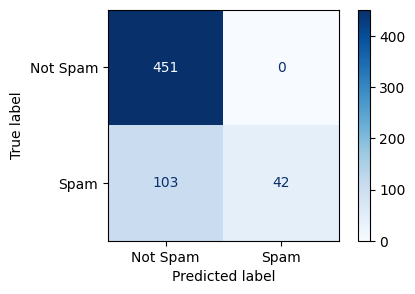

In [29]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_pred_mnb = mnb.predict(X_val)

fbeta_mb = evaluate(y_val, y_pred_mnb, beta)

#### 2. Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       451
           1       1.00      0.90      0.95       145

    accuracy                           0.97       596
   macro avg       0.98      0.95      0.96       596
weighted avg       0.98      0.97      0.97       596

f beta score: 0.9569120287253141


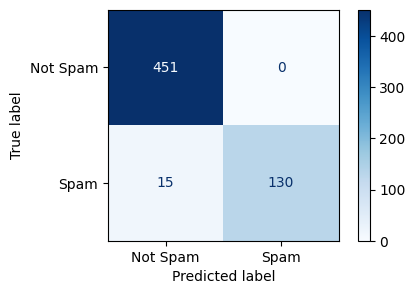

In [30]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

fbeta_lr = evaluate(y_val, y_pred_lr, beta)

#### 3. Decision Tree Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       451
           1       0.92      0.90      0.91       145

    accuracy                           0.95       596
   macro avg       0.94      0.93      0.94       596
weighted avg       0.95      0.95      0.95       596

f beta score: 0.9080068143100513


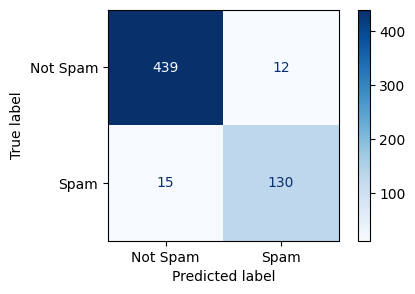

In [31]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_val)

fbeta_dt = evaluate(y_val, y_pred_dtc, beta)

#### 4. Random Forest Classifier

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       451
           1       0.99      0.89      0.94       145

    accuracy                           0.97       596
   macro avg       0.98      0.94      0.96       596
weighted avg       0.97      0.97      0.97       596

f beta score: 0.9495511669658886


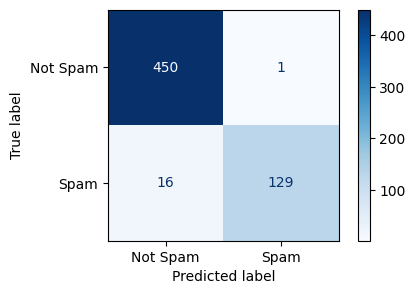

In [32]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_val)

fbeta_rf = evaluate(y_val, y_pred_rfc, beta)

The parameters used to train Random Forest Classifier are giving pretty good results, there is no need of hyperparameter tuning.

#### 5. Support Vector Classifier (SVC)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.77       451
           1       0.24      0.21      0.22       145

    accuracy                           0.64       596
   macro avg       0.50      0.50      0.50       596
weighted avg       0.63      0.64      0.63       596

f beta score: 0.22716711349419122


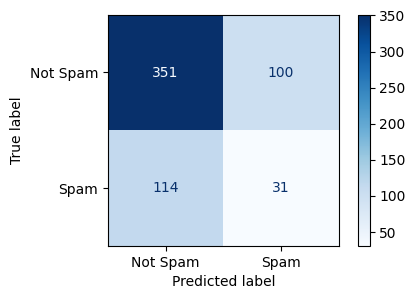

In [33]:
svc = SVC(kernel = "sigmoid")
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_val)

fbeta_svc = evaluate(y_val, y_pred_svc, beta)

### Precision Recall Curve
#### its just another method for comparing the models graphically.

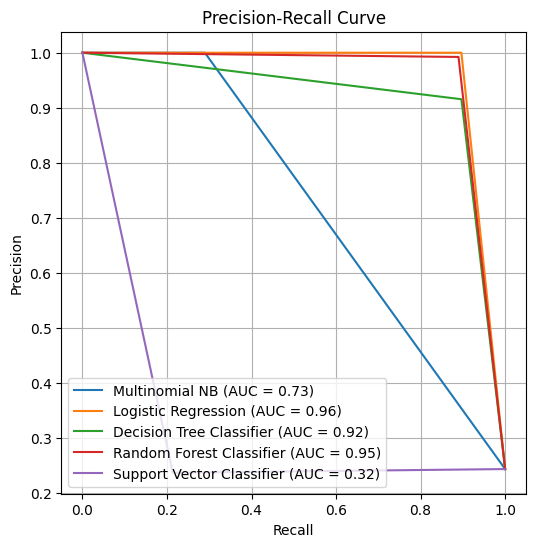

In [34]:
predictions = [
    ("Multinomial NB", y_pred_mnb),
    ("Logistic Regression", y_pred_lr),
    ("Decision Tree Classifier", y_pred_dtc),
    ("Random Forest Classifier", y_pred_rfc),
    ("Support Vector Classifier", y_pred_svc)
]

def pr_curve(predictions,y_val):
    plt.figure(figsize = (6, 6))
    for model_name, pred in predictions:
        precision, recall, _ = precision_recall_curve(y_val, pred)
        auc_score = auc(recall, precision)
        plt.plot(recall, precision, label = f"{model_name} (AUC = {auc_score:.2f})")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

pr_curve(predictions,y_val)



In [35]:
fbeta_scores = [fbeta_dt,fbeta_lr,fbeta_mb,fbeta_rf,fbeta_svc]
models = ['Decision Trees','Logistic Regression','Multinomial Naive Bayes', 'Random Forest', 'SVC']
# Combine lists into a dictionary
data = {'Models': models, 'Fbeta Scores': fbeta_scores}

# Create DataFrame
df_models = pd.DataFrame(data)

# Print the DataFrame
print(df_models)

                    Models  Fbeta Scores
0           Decision Trees      0.908007
1      Logistic Regression      0.956912
2  Multinomial Naive Bayes      0.510979
3            Random Forest      0.949551
4                      SVC      0.227167


##### The best 3 models from the above curve are `Logistic Regression`, `Random Forest Classifier`, `Decision Tree Classifier`

#### Hyper Parameter Tuning (Cross Validation)

#### From the chosen 3 models will do hyper parameter tuning and test it on validation data to finalise the model.

In [36]:
X_train_val = vstack([X_train,X_val])
y_train_val = pd.concat([y_train,y_val])

#### 1) Decision Trees

In [37]:
dt_model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'class_weight' : [None, 'balanced']
}

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring=scorer)

# Fit the model to the training data with cross-validation
grid_search.fit(X_train_val, y_train_val)
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       872
           1       0.91      0.92      0.92       274

    accuracy                           0.96      1146
   macro avg       0.94      0.95      0.94      1146
weighted avg       0.96      0.96      0.96      1146

f beta score: 0.9131965842063561


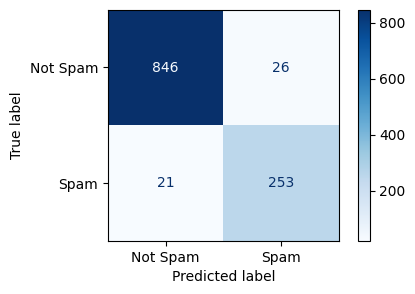

In [38]:
# Retrieve the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_dt_tuned = best_model.predict(X_test)

# Evaluate the model on the test set
fbeta_Score_dt_tuned = evaluate(y_test, y_pred_dt_tuned,beta)

#### 2) Logistic Regression

In [39]:

# Define the Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Define the hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring=scorer)

# Fit the model to the training data with cross-validation
grid_search.fit(X_train_val, y_train_val)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'C': 100, 'penalty': 'l2'}


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       872
           1       0.99      0.97      0.98       274

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146

f beta score: 0.9832045985270342


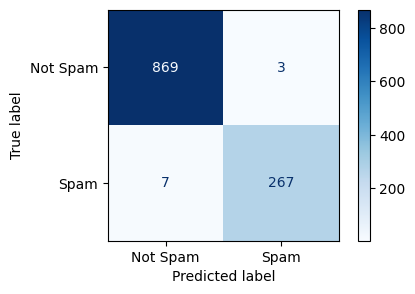

In [40]:
# Retrieve the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_lr_tuned = best_model.predict(X_test)

# Evaluate the model on the test set
fbeta_Score_lr_tuned = evaluate(y_test, y_pred_lr_tuned,beta)

#### 3) Random Forest

In [41]:
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameters to search
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5,7,None],
    'class_weight' : [None,'balanced']
}

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data with cross-validation
grid_search.fit(X_train_val, y_train_val)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 300}


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       872
           1       0.99      0.97      0.98       274

    accuracy                           0.99      1146
   macro avg       0.99      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146

f beta score: 0.9780358268070932


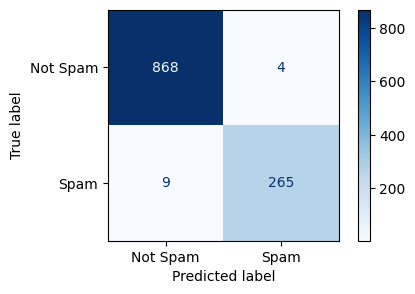

In [42]:
# Retrieve the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_rf_tuned = best_model.predict(X_test)

# Evaluate the model on the test set
fbeta_score_rf_tuned = evaluate(y_test, y_pred_rf_tuned, beta)

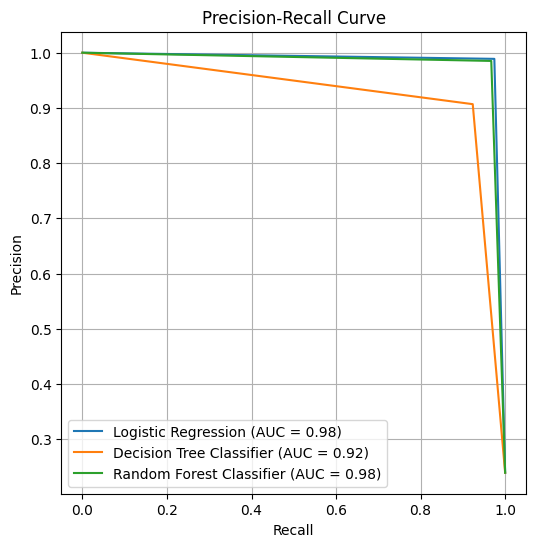

In [44]:
predictions = [
    ("Logistic Regression", y_pred_lr_tuned),
    ("Decision Tree Classifier", y_pred_dt_tuned),
    ("Random Forest Classifier", y_pred_rf_tuned)
]

pr_curve(predictions,y_test)

In [64]:
fbeta_scores_tuned = [fbeta_Score_dt_tuned,fbeta_Score_lr_tuned,fbeta_score_rf_tuned]
auc_Scores = [0.92,0.98,0.98]
models = ['Decision Trees','Logistic Regression','Random Forest']

# Combine lists into a dictionary
data = {'Tuned Models': models, 'Fbeta Scores': fbeta_scores_tuned, 'auc scores': auc_Scores}

# Create DataFrame
df_models_tuned = pd.DataFrame(data)

# Print the DataFrame
print(df_models_tuned)

          Tuned Models  Fbeta Scores  auc scores
0       Decision Trees      0.913197        0.92
1  Logistic Regression      0.983205        0.98
2        Random Forest      0.978036        0.98


#### So among these 3 we can go with Logistic Regression model since it is giving higher fbeta score and also easily interpretable.